Data from [Tempo: an unsupervised Bayesian algorithm for circadian phase inference in single-cell transcriptomics](https://doi.org/10.1038/s41467-022-34185-w)

In [54]:
import numpy as np
from CoPhaser import utils
from CoPhaser.trainer import Trainer
from CoPhaser.loss import Loss
from CoPhaser import plotting
from CoPhaser.model import CoPhaser
from CoPhaser import gene_sets
from CoPhaser.model import VAEModelLoader
import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import anndata
import scanpy as sc

import pandas as pd

DATA_FOLDER = "../../../data/"

In [55]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
adata = anndata.read_h5ad(f"{DATA_FOLDER}/aorta_circadian/adata_concatenated.h5ad")
adata

AnnData object with n_obs × n_vars = 22573 × 32285
    obs: 'batch', 'sample_id', 'sex', 'misaligned', 'zt', 'percent_mito', 'lib_size', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mito_qc_pass', 'umi_qc_pass', 'doublet_qc_pass', 'doublet_score', 'qc_pass', 'cluster', 'subcluster', 'log_L', 'phase', 'celltype'
    obsm: '2d_embedding', 'denoised_log_dispersion_hat', 'denoised_log_mean_hat', 'embedding'

In [57]:
adata.layers["total"] = adata.X.copy()

In [58]:
adata = adata[adata.obs["qc_pass"]].copy()

<Axes: ylabel='Count'>

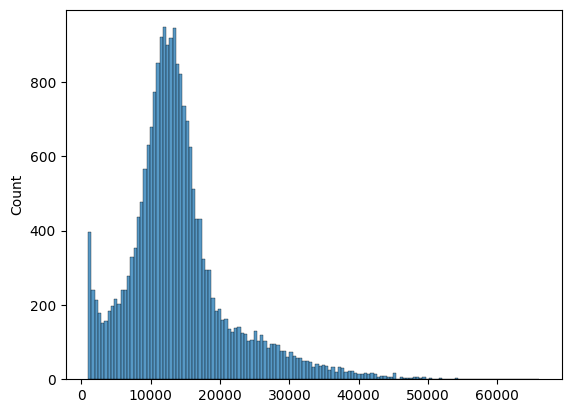

In [59]:
adata_all_genes = adata.copy()
layer_to_use = "total"
library_size = adata_all_genes.layers[layer_to_use].sum(axis=1).A1
sns.histplot(x=library_size)

In [60]:
# remove cells with less than 5000 counts
adata = adata_all_genes[library_size >= 5000].copy()

In [61]:
# replace Arntl by Bmal1
var_names = adata.var_names.tolist()
var_names[var_names.index("Arntl")] = "Bmal1"
adata.var_names = var_names

In [62]:
SMALL_CYCLING_GENE_SET = gene_sets.SMALL_CIRCADIAN_GENE_SET

In [63]:
g = utils.get_variable_genes(adata, 2000)
len(g)

2000

In [64]:
genes_tempo = [
    "Arntl",
    "Arntl2",
    "Bhlhe41",
    "Ciart",
    "Clock",
    "Cry1",
    "Cry2",
    "Csnk1a1",
    "Csnk1d",
    "Csnk1e",
    "Dbp",
    "Dec1",
    "Dec2",
    "Fbxo21",
    "Fbxo3",
    "Gm129",
    "Hlf",
    "Nampt",
    "Nfil3",
    "Npas2",
    "Nr1d1",
    "Nr1d2",
    "Per1",
    "Per2",
    "Per3",
    "Rora",
    "Rorc",
    "Tef",
]

In [65]:
SMALL_CYCLING_GENE_SET = np.array(
    list(
        set(list(gene_sets.SMALL_CIRCADIAN_GENE_SET) + genes_tempo)
        & set(adata.var_names)
    )
)

In [66]:
len(SMALL_CYCLING_GENE_SET)

25

In [67]:
amp_phase_circadian = {
    "Bmal1": (1, 5.5),
    "Npas2": (0.5, 5.5),
    "Rorc": (0.5, 5.7),
    "Nr1d1": (1, 2.0),
    "Nr1d2": (0.75, 2.09),
    "Tef": (0.75, 2.35),
    "Ciart": (1, 2.35),
    "Dbp": (1, 2.09),
    "Per3": (1, 2.36),
    "Cry1": (0.5, 4.71),
    "Cry2": (0.25, 3),
    "Per2": (0.6, 3.14),
    "Per1": (0.5, 3.14),
    "Hlf": (0.5, 3.14),
}

In [68]:
def optimal_shift(p, p0, n_s=200):
    """
    Aligns two sequences defined on the unit circle, taking care of the periodicity
    and the flipping symmetry of the circle.
    It uses the median absolute deviation (MAD) as a measure of the distance between the two sequences.

    Parameters:
    p: phase array to adjust
    p0: phase array (reference)
    n_s: number of shifts to consider

    Returns:
    phi_aligned: the aligned phase array
    best_mad: the MAD of the best alignment
    """

    def circular_deviation2(x, y, period=2 * np.pi):
        """
        Function called by optimal_shift
        Inputs:
        x: phase array
        y: phase array
        period: period of the circular variable
        """
        x, y = x % period, y % period
        v1 = np.abs(x - y)
        v2 = (period - v1) % period

        return np.minimum(v1, v2)

    Nc = p.shape[0]
    shifts = np.linspace(0, 2 * np.pi, n_s)
    # creating a matrix of all possible shifts
    theta_cs = (p.reshape(Nc, 1) - shifts.reshape(1, n_s)) % (2 * np.pi)
    theta_cs_neg = (-p.reshape(Nc, 1) - shifts.reshape(1, n_s)) % (2 * np.pi)

    # for each shift, computing the circular deviation, using apply_along_axis
    delta_cs = circular_deviation2(p0[:, None], theta_cs)
    delta_cs_neg = circular_deviation2(p0[:, None], theta_cs_neg)

    # computing the median absolute deviation for all shifts
    v = np.median(delta_cs, axis=0)
    v_neg = np.median(delta_cs_neg, axis=0)
    # selecting the best shift
    best_shift_ind = np.argmin(v)
    best_shift_ind_neg = np.argmin(v_neg)
    mad, mad_neg = v[best_shift_ind], v_neg[best_shift_ind_neg]

    # selecting which direction is the best
    if mad < mad_neg:
        phi_aligned = theta_cs[:, best_shift_ind]
        best_mad = mad
    else:
        phi_aligned = theta_cs_neg[:, best_shift_ind_neg]
        best_mad = mad_neg

    return phi_aligned, best_mad


def get_MAD(adata, thetas):
    w = 2 * np.pi / 24
    true_phase = (adata.obs.zt.values % 24) * w
    if not isinstance(thetas, np.ndarray):
        thetas = thetas.detach().numpy()
    phi = thetas % (2 * np.pi)

    _, mad = optimal_shift(phi, true_phase)
    return mad / w

In [69]:
celltypes = adata.obs["celltype"].unique()

mad = {}
for ct in celltypes:
    mad[ct] = []

for _ in tqdm.tqdm(range(5)):
    model = CoPhaser(
        SMALL_CYCLING_GENE_SET,
        g,
        n_latent=10,
        n_harm=1,
        rhythmic_decoder_to_all_genes=True,
        use_mu_z_encoder=True,
        use_amp_Z=True,
        z_range=20,
    )
    model.load_anndata(adata, layer_to_use="total")

    VAEModelLoader.define_decoder_prior(
        amp_phase_prior=amp_phase_circadian, model=model
    )
    trainer = Trainer(
        model,
        Loss.compute_loss,
        non_rhythmic_likelihood_weight=2,
        rhythmic_likelihood_weight=10,
        unfreeze_epoch_layer=[(10, "rhythmic_decoder")],
        L2_Z_decoder_loss_weight=0,
        closed_circle_weight=0,
        MI_weight=50,
        entropy_weight_factor=50,
        cycling_status_prior=1,
        MI_detach="f",
    )
    trainer.train_model(
        n_epochs=200,
        lr=1e-2,
        device="cuda",
        batch_size=2048,
        ,
        silent=True,
    )
    # Get the infered theta values
    model.to("cpu")
    generative_outputs, space_outputs = model.get_outputs()
    # thetas = model.infer_pseudotimes(adata,"total",False)
    thetas = space_outputs["theta"].detach().cpu().numpy()
    for ct in celltypes:
        i = adata.obs["celltype"] == ct
        mad[ct].append(get_MAD(adata[i], thetas[i]))

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 5/5 [07:21<00:00, 88.34s/it]


In [70]:
# get the mean and std of the MADs
mad_mean = {}
mad_std = {}
for ct in celltypes:
    mad_mean[ct] = np.mean(mad[ct])
    mad_std[ct] = np.std(mad[ct])
mad_mean, mad_std

({'endothelial': 2.8410403994086555,
  'fibroblast': 2.007619985168788,
  'macrophage': 2.2908651479529096,
  'smc': 1.726606739829815},
 {'endothelial': 0.06605527522457946,
  'fibroblast': 0.03896348804246991,
  'macrophage': 0.13765104910835646,
  'smc': 0.09771247822785137})

In [71]:
for ct in ["smc", "fibroblast", "endothelial", "macrophage"]:
    print(f"{ct}: {mad_mean[ct]:.2f} ({mad_std[ct]:.2f}) ")

smc: 1.73 (0.10) 
fibroblast: 2.01 (0.04) 
endothelial: 2.84 (0.07) 
macrophage: 2.29 (0.14) 


In [72]:
# test random assignments of phases
mad_random = {}
for ct in celltypes:
    n_cells = adata.obs["celltype"].value_counts()[ct]
    mad_random[ct] = []
    for _ in range(5):
        random_thetas = np.random.uniform(0, 2 * np.pi, n_cells)
        i = adata.obs["celltype"] == ct
        mad_random[ct].append(get_MAD(adata[i], random_thetas))
mad_random_mean = {}
mad_random_std = {}
for ct in celltypes:
    mad_random_mean[ct] = np.mean(mad_random[ct])
    mad_random_std[ct] = np.std(mad_random[ct])
for ct in ["smc", "fibroblast", "endothelial", "macrophage"]:
    print(f"{ct}: {mad_random_mean[ct]:.2f} ({mad_random_std[ct]:.2f}) ")

smc: 5.89 (0.02) 
fibroblast: 5.74 (0.03) 
endothelial: 4.97 (0.35) 
macrophage: 5.10 (0.13) 
